#MACHINE LEARNING PROJECT : **DETECTION DU DIABETE**

###importer les modules et packages nécessaire

In [32]:
# Install necessary libraries
!pip install ucimlrepo

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

# Import classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import sampling technique
from imblearn.over_sampling import SMOTE

# Import joblib for saving and loading models
from joblib import dump, load


# COLLECTE DES DONNEES

In [33]:
from ucimlrepo import fetch_ucirepo
#https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators


# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)


# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [36]:
X.shape, y.shape

((253680, 21), (253680, 1))

In [38]:
# Concaténer les DataFrames côte à côte
data = pd.concat([X, y], axis=1)

data_copy=data.copy()


In [40]:


# Définition des mappages des codes aux étiquettes pour chaque variable
mappings = {
    'Diabetes_binary': {0: 'No Diabetes', 1: 'Prediabetes/Diabetes'},
    'HighBP': {0: 'No High BP', 1: 'High BP'},
    'HighChol': {0: 'No High Cholesterol', 1: 'High Cholesterol'},
    'CholCheck': {0: 'No Cholesterol Check in 5 Years', 1: 'Cholesterol Check in 5 Years'},
    'Smoker': {0: 'Non-Smoker', 1: 'Smoker'},
    'Stroke': {0: 'No Stroke', 1: 'Stroke'},
    'HeartDiseaseorAttack': {0: 'No Heart Disease or Attack', 1: 'Heart Disease or Attack'},
    'PhysActivity': {0: 'No Physical Activity', 1: 'Physical Activity'},
    'Fruits': {0: 'No', 1: 'Yes'},
    'Veggies': {0: 'No', 1: 'Yes'},
    'HvyAlcoholConsump': {0: 'No', 1: 'Yes'},
    'AnyHealthcare': {0: 'No', 1: 'Yes'},
    'NoDocbcCost': {0: 'No', 1: 'Yes'},
    'DiffWalk': {0: 'No', 1: 'Yes'},
    'Sex': {0: 'Female', 1: 'Male'},
    'Education': {
        1: 'Never attended school or only kindergarten',
        2: 'Grades 1 through 8 (Elementary)',
        3: 'Grades 9 through 11 (Some high school)',
        4: 'Grade 12 or GED (High school graduate)',
        5: 'College 1 year to 3 years (Some college or technical school)',
        6: 'College 4 years or more (College graduate)'
    },
    'Age' : {
        1: "18-24",
        2: "25-29",
        3: "30-34",
        4: "35-39",
        5: "40-44",
        6: "45-49",
        7: "50-54",
        8: "55-59",
        9: "60-64",
        10: "65-69",
        11: "70-74",
        12: "75-79",
        13: "80+"
    }
}

# Appliquer le mappage pour décoder les variables, en utilisant la même boucle que précédemment
for variable, mapping in mappings.items():
    data[variable] = data[variable].map(mapping)




# EXPLORATION DES DONNEES (Statistiques descriptives)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   HighBP                253680 non-null  object
 1   HighChol              253680 non-null  object
 2   CholCheck             253680 non-null  object
 3   BMI                   253680 non-null  int64 
 4   Smoker                253680 non-null  object
 5   Stroke                253680 non-null  object
 6   HeartDiseaseorAttack  253680 non-null  object
 7   PhysActivity          253680 non-null  object
 8   Fruits                253680 non-null  object
 9   Veggies               253680 non-null  object
 10  HvyAlcoholConsump     253680 non-null  object
 11  AnyHealthcare         253680 non-null  object
 12  NoDocbcCost           253680 non-null  object
 13  GenHlth               253680 non-null  int64 
 14  MentHlth              253680 non-null  int64 
 15  PhysHlth         

# Recherche de valeurs maquantes:

In [46]:
pd.DataFrame({'Nombre NA': data_copy.isna().sum(),
              'Pourcentage NA (%)': round((data_copy.isna().sum() / len(data_copy)) *100,2)}).sort_values(by='Pourcentage NA (%)', ascending=False)

,Nombre NA,Pourcentage NA (%)
HighBP,0,0.0
HighChol,0,0.0
Income,0,0.0
Education,0,0.0
Age,0,0.0
Sex,0,0.0
DiffWalk,0,0.0
PhysHlth,0,0.0
MentHlth,0,0.0
GenHlth,0,0.0


# Représentations des variables catégorielles nominales

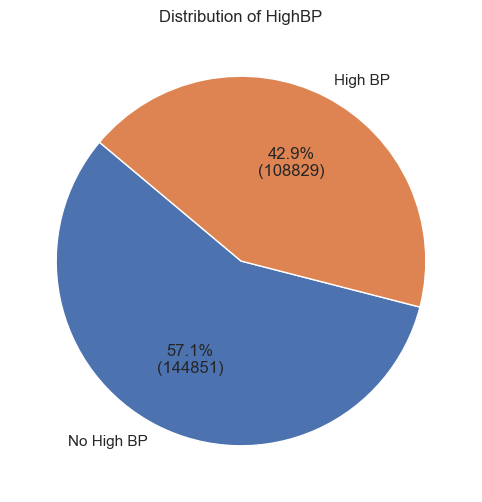

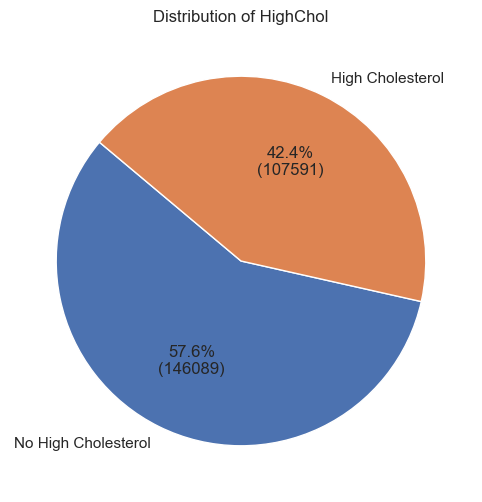

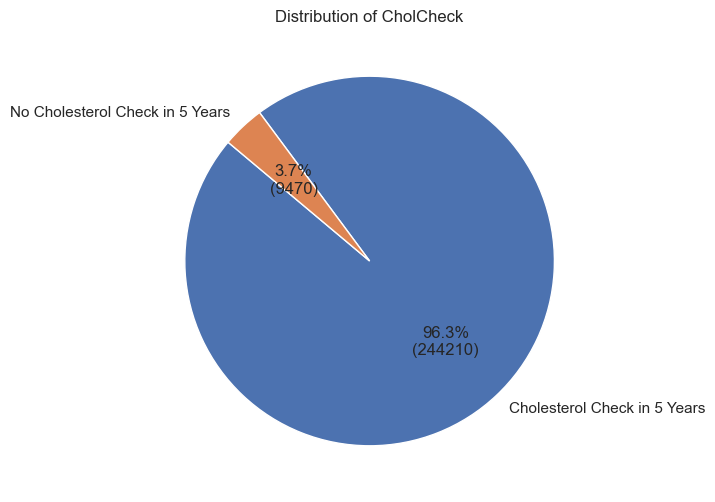

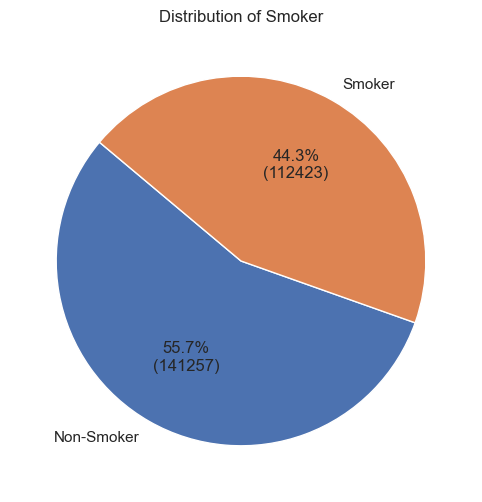

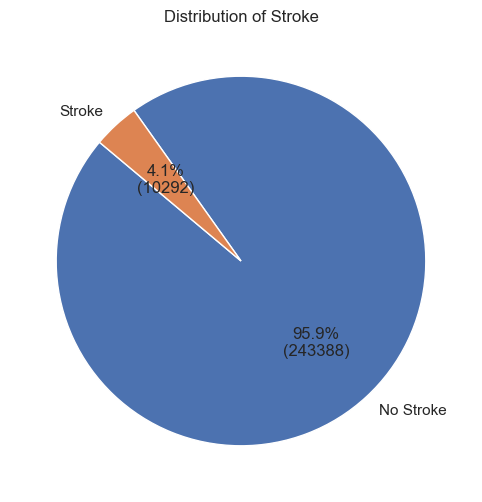

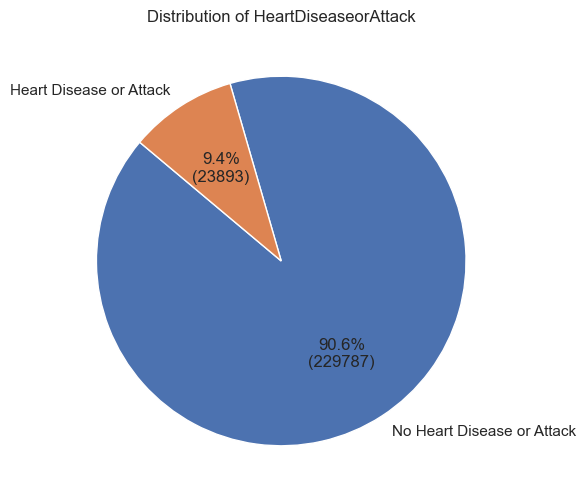

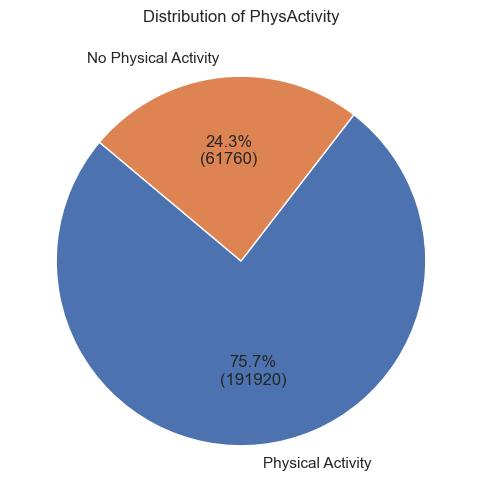

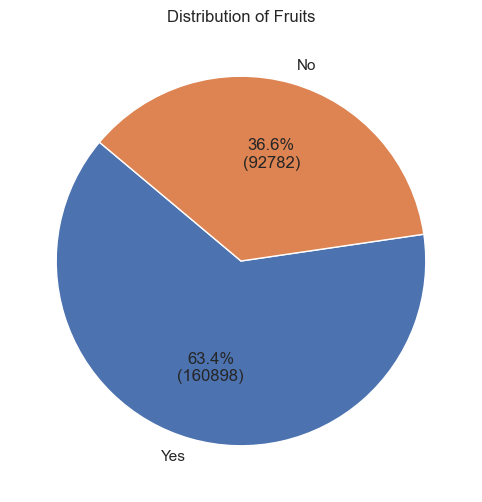

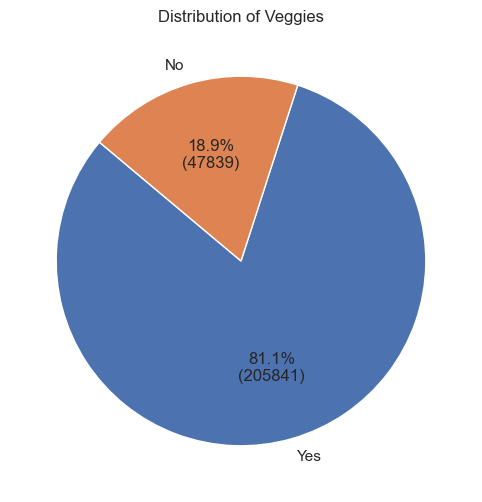

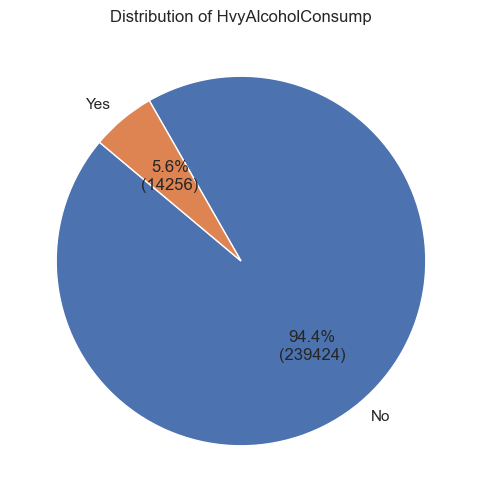

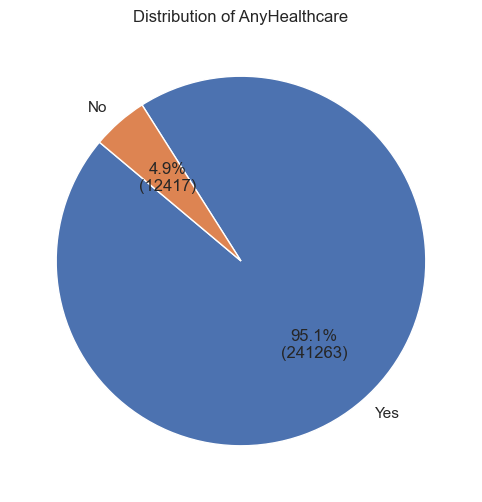

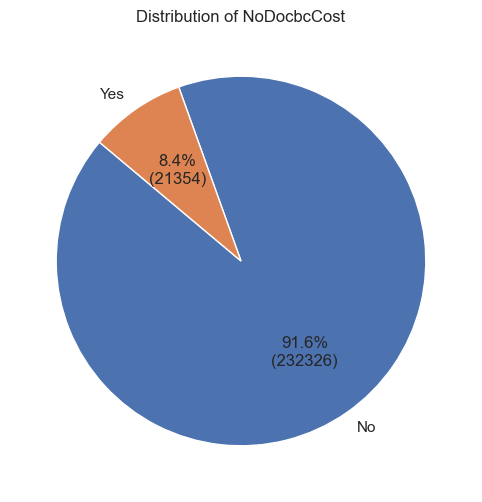

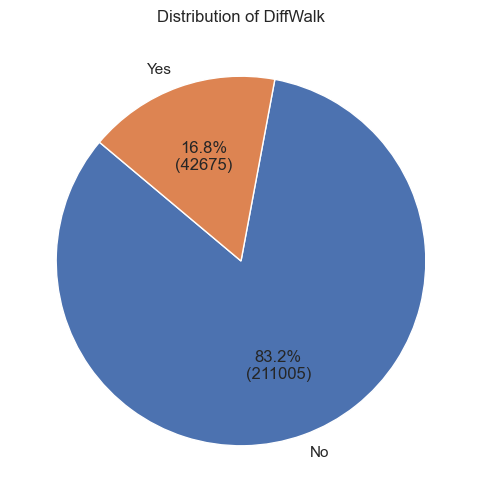

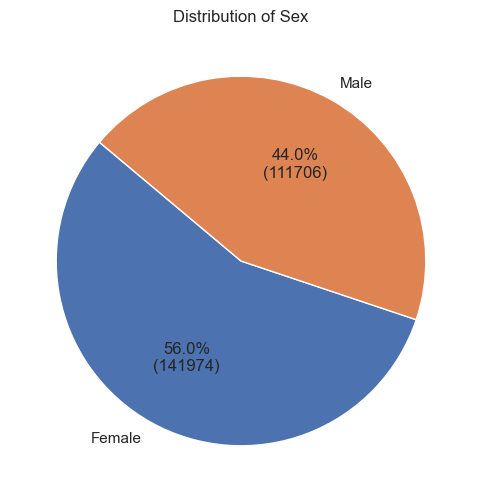

In [48]:
# Définir le style Seaborn pour les graphiques
sns.set(style="whitegrid")

# Liste des variables à tracer
variables = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]

# Fonction pour tracer un diagramme circulaire pour une variable donnée
def plot_pie_chart(variable, df):
    counts = df[variable].value_counts()
    total = counts.sum()

    def autopct_format(percent):
        total_count = int(round(percent*total/100.0))
        return '{:.1f}%\n({:d})'.format(percent, total_count)

    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=counts.index, autopct=autopct_format, startangle=140)
    plt.title(f'Distribution of {variable}')
    plt.show()

# Boucler sur chaque variable et créer un diagramme circulaire
for variable in variables:
    plot_pie_chart(variable, data)


# Représentations des variables catégorielles ordinales

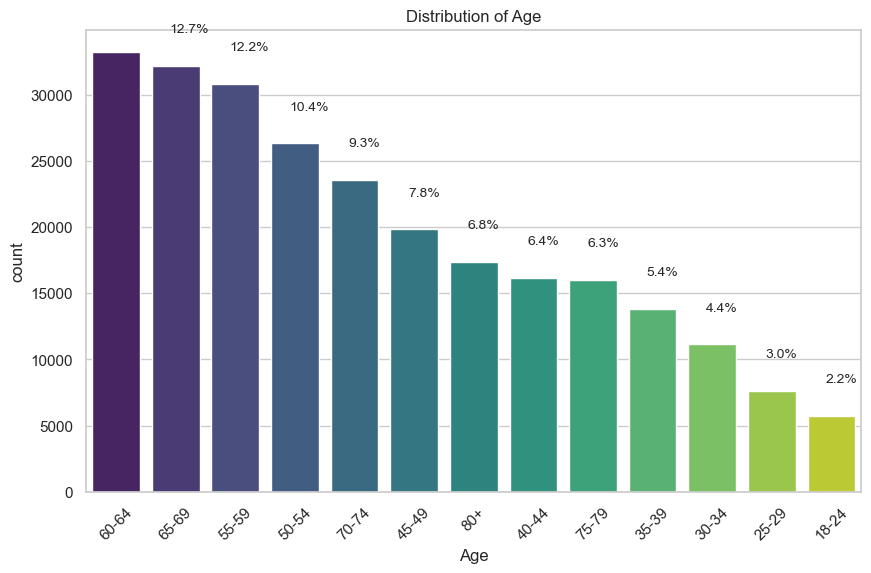

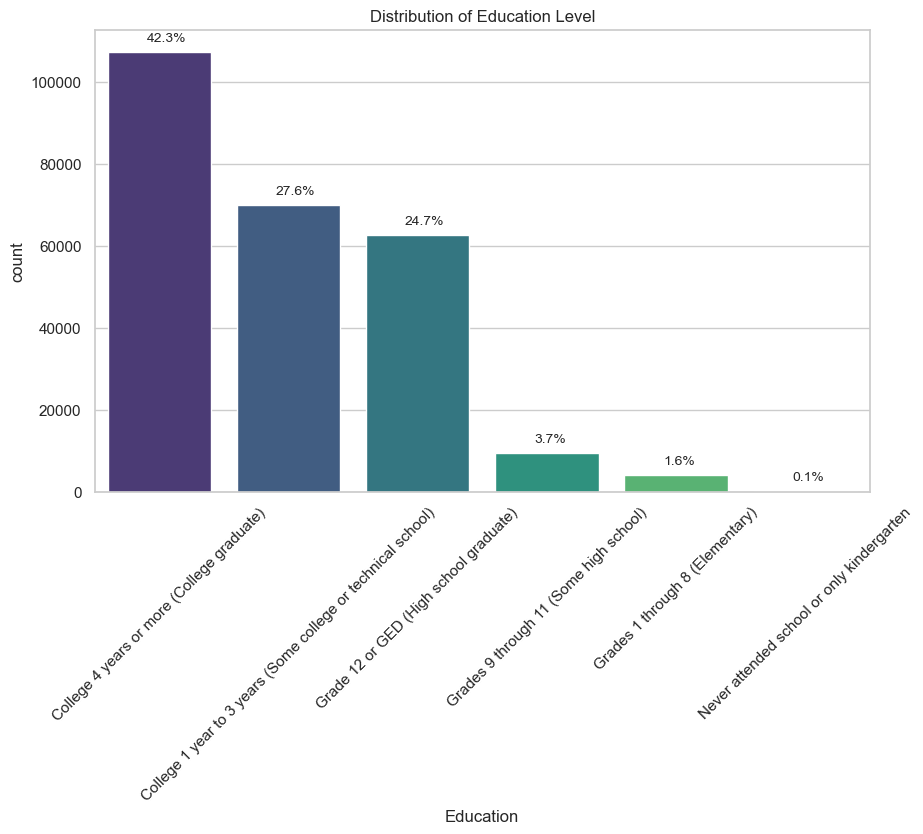

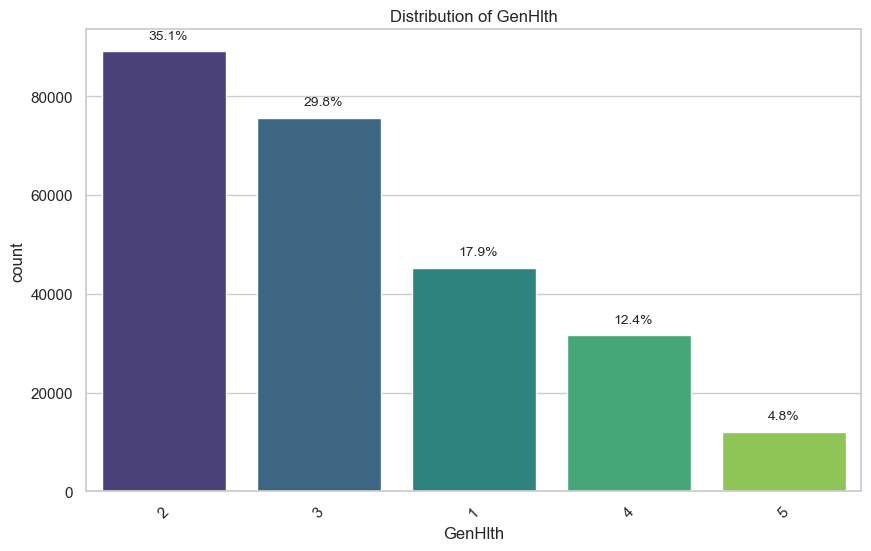

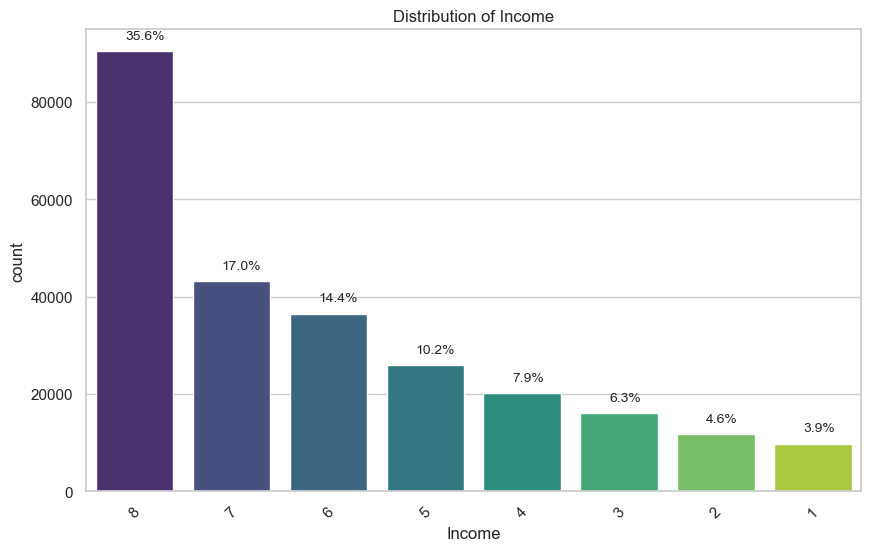

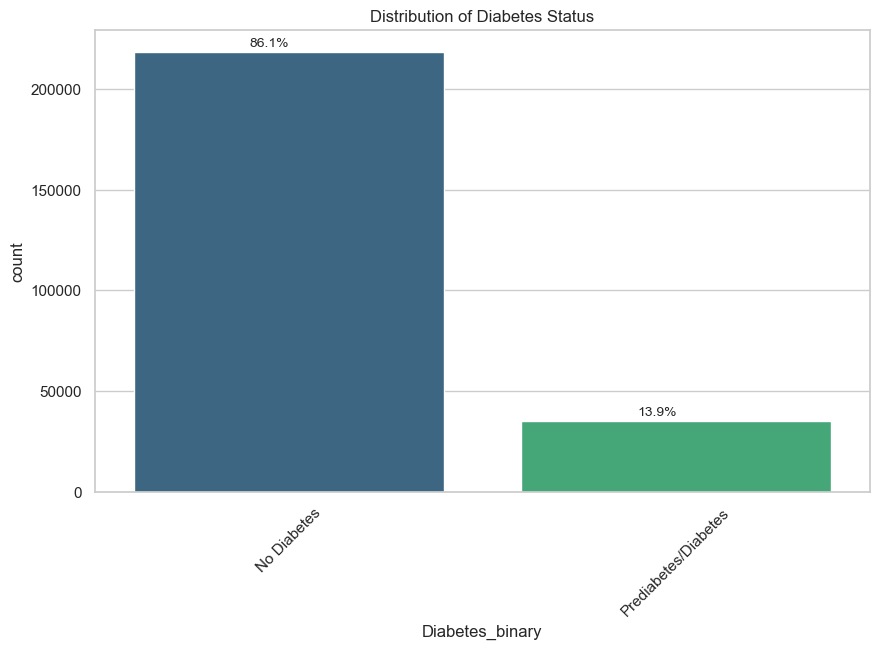

In [50]:
# Définir le style Seaborn pour les graphiques
sns.set(style="whitegrid")

# Dictionnaire des variables et leurs titres pour les graphiques
variables = {
    'Age': 'Distribution of Age',
    'Education': 'Distribution of Education Level',
    'GenHlth' : 'Distribution of GenHlth' ,
    'Income' : 'Distribution of Income',
    'Diabetes_binary': 'Distribution of Diabetes Status'
}

# Boucler sur chaque variable et créer un diagramme en barres
for variable, title in variables.items():
    plt.figure(figsize=(10, 6))
    # Création du countplot
    ax = sns.countplot(data=data, x=variable, palette='viridis', order=data[variable].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)

    # Calcul et affichage des pourcentages au-dessus des barres
    total = len(data[variable])  # Nombre total d'observations
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_y() + p.get_height() + 0.01*total
        ax.annotate(percentage, (x, y), size = 10)

    plt.show()


# Représentations des variables quantitatives discretes

C:\Users\ouatt\AppData\Local\Temp\ipykernel_13864\2075039063.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=variable, kde=True, palette='viridis', bins=30, edgecolor='k')
C:\Users\ouatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


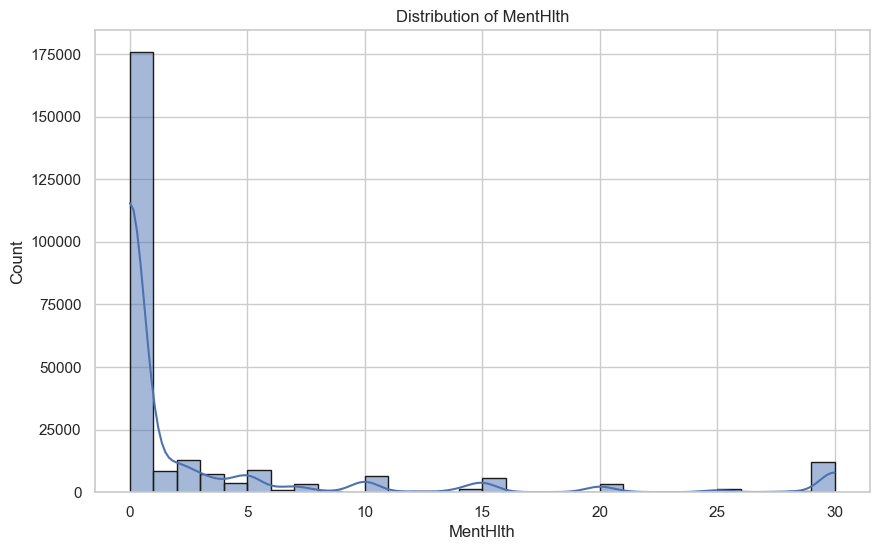

C:\Users\ouatt\AppData\Local\Temp\ipykernel_13864\2075039063.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=variable, kde=True, palette='viridis', bins=30, edgecolor='k')
C:\Users\ouatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


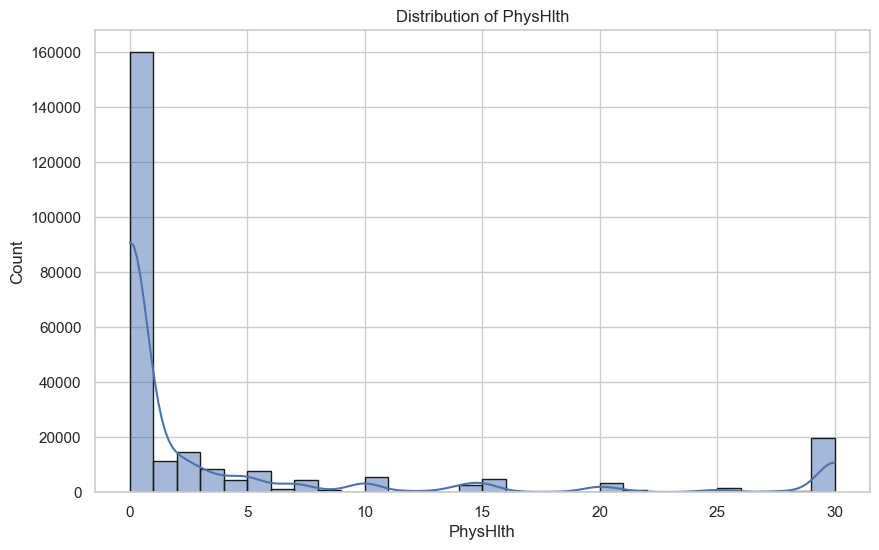

C:\Users\ouatt\AppData\Local\Temp\ipykernel_13864\2075039063.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=variable, kde=True, palette='viridis', bins=30, edgecolor='k')
C:\Users\ouatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


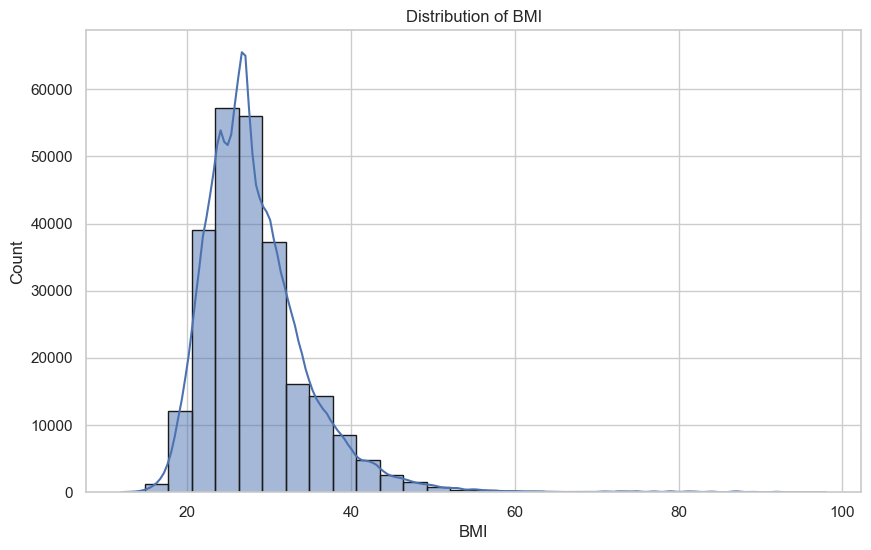

In [59]:
# Définir le style Seaborn pour les graphiques
sns.set(style="whitegrid")

# Liste des variables à tracer
variables = ['MentHlth', 'PhysHlth', 'BMI']

# Boucler sur chaque variable et créer des histogrammes et des courbes de densité
for variable in variables:
    plt.figure(figsize=(10, 6))

    # Créer un histogramme avec une courbe de densité
    sns.histplot(data=data, x=variable, kde=True, palette='viridis', bins=30, edgecolor='k')

    # Ajouter un titre
    plt.title(f'Distribution of {variable}')

    plt.show()


# Statistiques somaires des variables quantitatives discretes

In [61]:


# Sélectionner les variables d'intérêt
variables = ['MentHlth', 'PhysHlth', 'BMI' ]

# Calculer les statistiques descriptives pour ces variables
descriptive_stats = data[variables].describe()


# Pour afficher les statistiques transposées (variables en lignes pour une meilleure lisibilité)
descriptive_stats_transposed = descriptive_stats.T

print(descriptive_stats_transposed)


             count       mean       std   min   25%   50%   75%   max
MentHlth  253680.0   3.184772  7.412847   0.0   0.0   0.0   2.0  30.0
PhysHlth  253680.0   4.242081  8.717951   0.0   0.0   0.0   3.0  30.0
BMI       253680.0  28.382364  6.608694  12.0  24.0  27.0  31.0  98.0


# Observer les corrélations avec la target : Test de student, Boxplot, Test de Chi 2 et matrice de taux de khindall

Test t pour 'MentHlth' par rapport à 'Diabetes_binary':
T-statistic: nan, P-value: nan


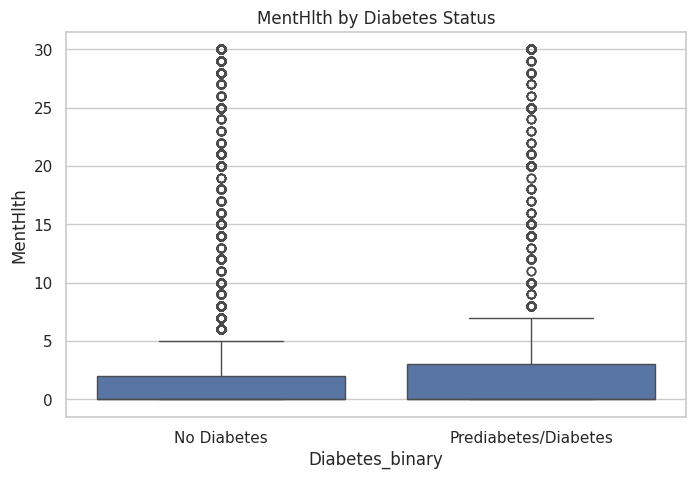

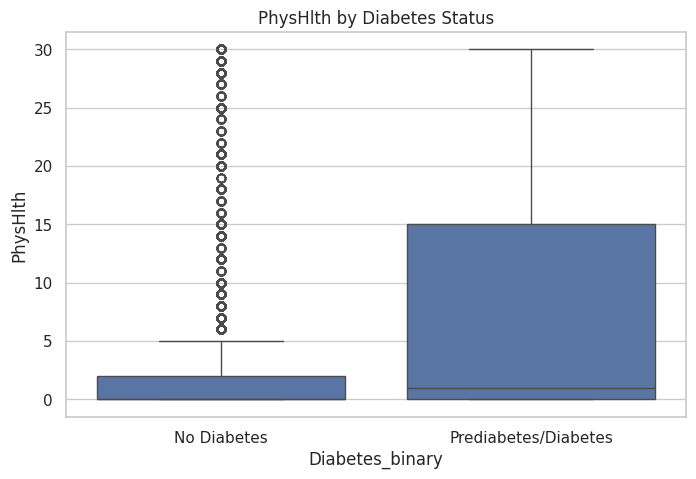

Variable: HighBP, Chi-square test, p-value: 0.0
Variable: HighChol, Chi-square test, p-value: 0.0
Variable: CholCheck, Chi-square test, p-value: 3.7513988789188705e-233
Variable: Smoker, Chi-square test, p-value: 8.640171809942516e-206
Variable: Stroke, Chi-square test, p-value: 0.0
Variable: HeartDiseaseorAttack, Chi-square test, p-value: 0.0
Variable: PhysActivity, Chi-square test, p-value: 0.0
Variable: Fruits, Chi-square test, p-value: 1.0881213885155634e-93
Variable: Veggies, Chi-square test, p-value: 1.4630291539062376e-178
Variable: HvyAlcoholConsump, Chi-square test, p-value: 1.8659318101056406e-181
Variable: AnyHealthcare, Chi-square test, p-value: 2.986181073970452e-16
Variable: NoDocbcCost, Chi-square test, p-value: 2.218395410122378e-56
Variable: DiffWalk, Chi-square test, p-value: 0.0
Variable: Sex, Chi-square test, p-value: 2.1098747365768505e-56


In [12]:
#pro 1
# Séparer les observations selon la variable cible 'Diabetes_binary'
group1 = data[data['Diabetes_binary'] == 'No']['MentHlth']
group2 = data[data['Diabetes_binary'] == 'Yes']['MentHlth']

# Effectuer le test t entre les deux groupes
t_stat, p_value = ttest_ind(group1, group2)

print("Test t pour 'MentHlth' par rapport à 'Diabetes_binary':")
print(f"T-statistic: {t_stat}, P-value: {p_value}")




#pro 2

# Variables continues
cont_variables = ['MentHlth', 'PhysHlth']

# Pour chaque variable continue, créer un boxplot par rapport à 'Diabetes_binary'
for var in cont_variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Diabetes_binary', y=var, data=data)
    plt.title(f'{var} by Diabetes Status')
    plt.show()




#pro 3

# Variables catégorielles
cat_variables = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',

    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]

# Test du chi-square pour chaque variable catégorielle
for var in cat_variables:
    contingency_table = pd.crosstab(data[var], data['Diabetes_binary'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Variable: {var}, Chi-square test, p-value: {p}')


###"Matrice de taux de Kendall"

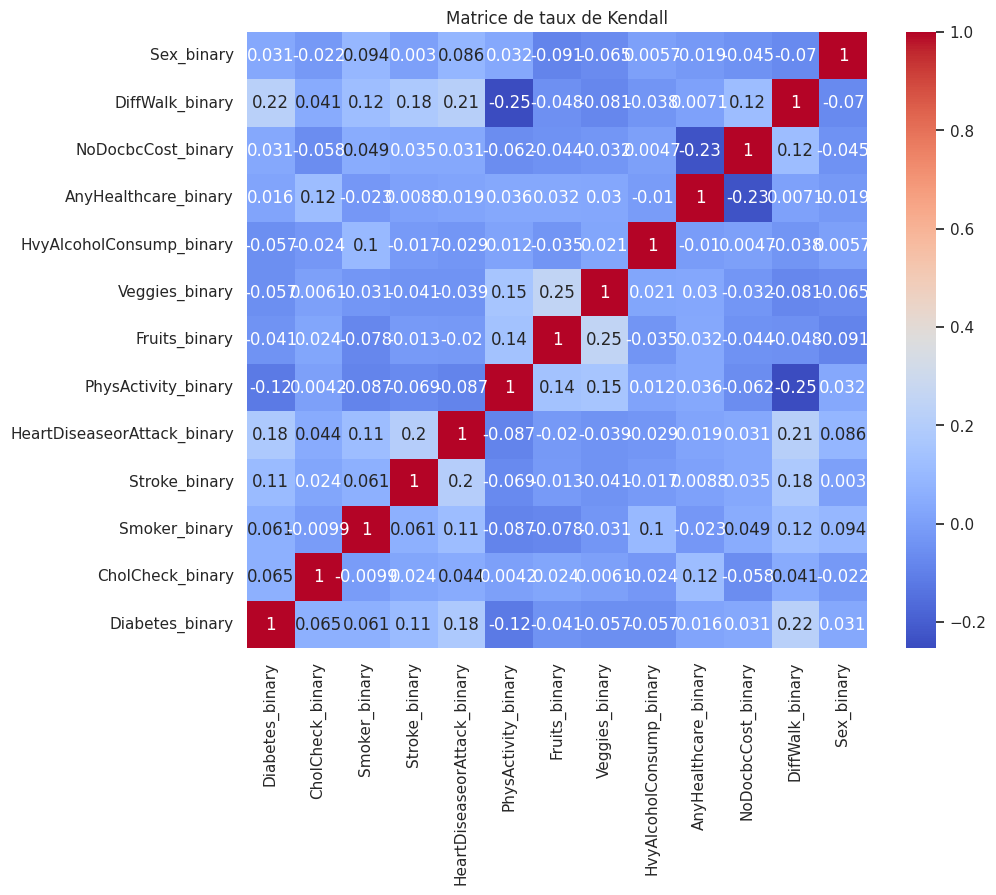

In [13]:
def to_binary_variable(data, column_name, positive_value):

    ##Convertit une variable en une variable binaire.

    binary_column = data[column_name] == positive_value
    data[column_name + '_binary'] = binary_column.astype(int)
    return data

data_cor=data
data_cor = to_binary_variable(data_cor,'HighBP','high BP')
data_cor = to_binary_variable(data_cor,'HighChol','high cholesterol')
data_cor = to_binary_variable(data_cor,'CholCheck','Cholesterol Check in 5 Years')
data_cor = to_binary_variable(data_cor,'Smoker','Smoker')
data_cor = to_binary_variable(data_cor,'Stroke','Stroke')
data_cor = to_binary_variable(data_cor,'HeartDiseaseorAttack','Heart Disease or Attack')
data_cor = to_binary_variable(data_cor,'PhysActivity','Physical Activity')
data_cor= to_binary_variable(data_cor,'Fruits','Yes')
data_cor = to_binary_variable(data_cor,'Veggies','Yes')
data_cor = to_binary_variable(data_cor,'HvyAlcoholConsump','Yes')
data_cor = to_binary_variable(data_cor,'AnyHealthcare','Yes')
data_cor = to_binary_variable(data_cor,'NoDocbcCost','Yes')
data_cor = to_binary_variable(data_cor,'DiffWalk','Yes')
data_cor = to_binary_variable(data_cor,'Sex','Male')

from scipy.stats import kendalltau
donnees_binaires = {
    'Diabetes_binary': data_cor['Diabetes_binary'],
    'CholCheck_binary': data_cor['CholCheck_binary'],
    'Smoker_binary': data_cor['Smoker_binary'],
    'Stroke_binary': data_cor['Stroke_binary'],
    'HeartDiseaseorAttack_binary': data_cor['HeartDiseaseorAttack_binary'],
    'PhysActivity_binary': data_cor['PhysActivity_binary'],
    'Fruits_binary': data_cor['Fruits_binary'],
    'Veggies_binary': data_cor['Veggies_binary'],
    'HvyAlcoholConsump_binary': data_cor['HvyAlcoholConsump_binary'],
    'AnyHealthcare_binary': data_cor['AnyHealthcare_binary'],
    'NoDocbcCost_binary': data_cor['NoDocbcCost_binary'],
    'DiffWalk_binary': data_cor['DiffWalk_binary'],
    'Sex_binary': data_cor['Sex_binary']
}

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Initialiser une matrice pour stocker les coefficients de corrélation
correlation_matrix = np.zeros((len(donnees_binaires), len(donnees_binaires)))

# Calculer le coefficient de corrélation de Kendall pour chaque paire de variables
variables = list(donnees_binaires.keys())
for i in range(len(variables)):
    var1 = variables[i]
    values1 = donnees_binaires[var1]
    for j in range(i, len(variables)):
        var2 = variables[j]
        values2 = donnees_binaires[var2]
        correlation_coefficient, _ = kendalltau(values1, values2)
        correlation_matrix[i, j] = correlation_coefficient
        correlation_matrix[j, i] = correlation_coefficient

# Créer une heatmap avec seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, xticklabels=variables, yticklabels=variables, cmap="coolwarm")
plt.title("Matrice de taux de Kendall")

# Inverser l'ordre des variables sur l'axe y
heatmap.invert_yaxis()

plt.show()

# TRAITEMENT DES DONNEES (PREPROCESSING)

In [14]:
data=data_copy

##Valeur manquante  : pas de valeur manquante

In [15]:


#Recherche de valeurs maquantes:
pd.DataFrame({'Nombre NA': data_copy.isna().sum(),
              'Pourcentage NA (%)': round((data_copy.isna().sum() / len(data_copy)) *100,2)}).sort_values(by='Pourcentage NA (%)', ascending=False)

,Nombre NA,Pourcentage NA (%)
HighBP,0,0.0
HighChol,0,0.0
Income,0,0.0
Education,0,0.0
Age,0,0.0
Sex,0,0.0
DiffWalk,0,0.0
PhysHlth,0,0.0
MentHlth,0,0.0
GenHlth,0,0.0


## Normalisation des varibales quantitatives et encodage OneHotEncoding des variables catégorielles nominales

In [18]:


def preprocessing(df):

    categorical_columns = ['Stroke', 'HeartDiseaseorAttack', 'AnyHealthcare', 'NoDocbcCost', 'Sex']
    numeric_columns = ['MentHlth', 'PhysHlth', 'BMI']

    # Initialisation de OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop="first")

    # Application de l'encodage OneHot aux colonnes catégorielles
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])

    # Création d'un DataFrame avec les colonnes encodées
    one_hot_data = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    # Concaténation du DataFrame encodé avec le DataFrame original
    df_encoded = pd.concat([df, one_hot_data], axis=1)

    # Suppression des colonnes catégorielles originales
    df = df_encoded.drop(categorical_columns, axis=1)

    # Initialisation de StandardScaler
    scaler = StandardScaler()

    # Standardisation des colonnes numériques
    scaled_data = scaler.fit_transform(df[numeric_columns])

    # Création d'un DataFrame pour les données normalisées
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns)

    # Concaténation des données standardisées avec le reste du DataFrame
    df= pd.concat([df.drop(numeric_columns, axis=1), scaled_df], axis=1)

    X = df.drop('Diabetes_binary', axis=1)
    y = df['Diabetes_binary']
    data=df


    return data, X, y



data, X, y= preprocessing(data_copy)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#features importance avec du RandomForest

In [19]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de Random Forest
rf = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)

# Entraînement du modèle
rf.fit(X_train, y_train)

# Obtenir l'importance des variables
feature_importances = rf.feature_importances_

# Créer un DataFrame pour visualiser les importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Trier les features par importance décroissante
features_df = features_df.sort_values(by='Importance', ascending=False)

# Affichage des importances des variables
print(features_df)


                   Feature  Importance
20                     BMI    0.171371
10                     Age    0.127835
8                  GenHlth    0.103232
12                  Income    0.085231
0                   HighBP    0.077554
19                PhysHlth    0.070758
11               Education    0.058432
18                MentHlth    0.053768
1                 HighChol    0.037056
3                   Smoker    0.029042
5                   Fruits    0.028225
9                 DiffWalk    0.025125
17                   Sex_1    0.024879
4             PhysActivity    0.022656
6                  Veggies    0.022015
14  HeartDiseaseorAttack_1    0.018820
16           NoDocbcCost_1    0.011912
13                Stroke_1    0.009878
7        HvyAlcoholConsump    0.008934
15         AnyHealthcare_1    0.007534
2                CholCheck    0.005742


#Représentation des variables selon leur importance

<Axes: >

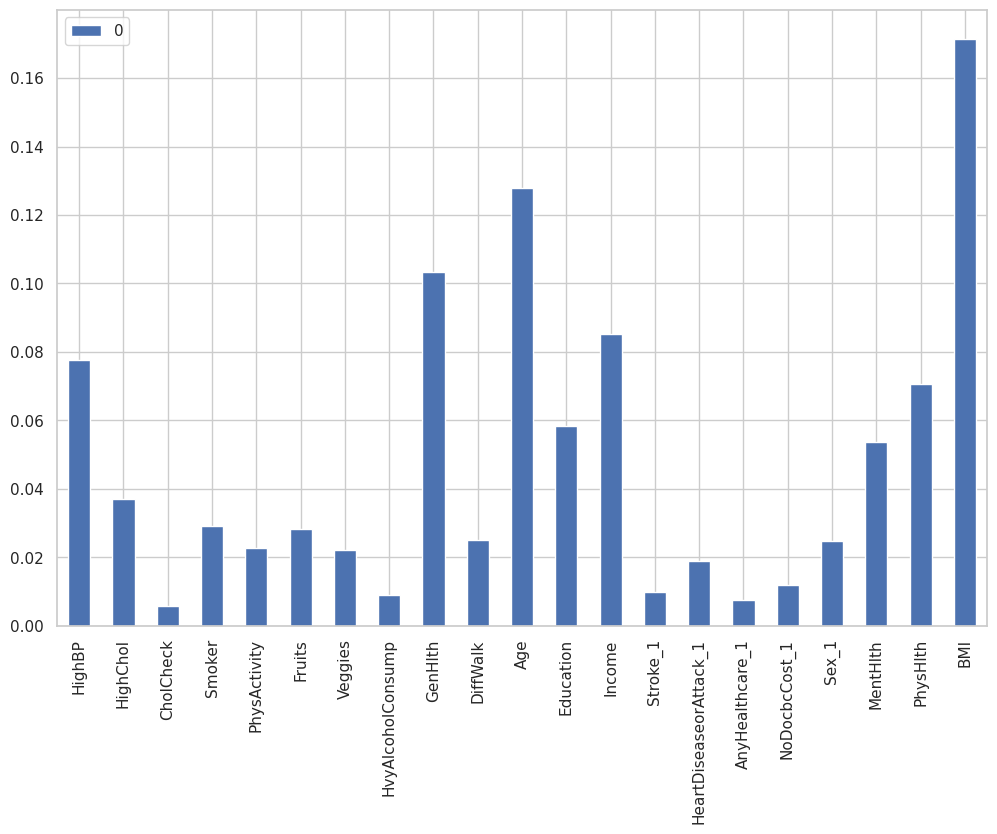

In [20]:



# Division des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement d'un modèle de forêt aléatoire
model_1 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_1.fit(X_train, y_train)

# Création d'un DataFrame des importances des caractéristiques et affichage sous forme de graphique en barres
importances = pd.DataFrame(model_1.feature_importances_, index=X_train.columns)
importances.plot.bar(figsize=(12, 8))


##Représenter l'évolution de l'acurancy en introduisant itérativement les variables et par importnace de variables

In [21]:



# Liste des caractéristiques triées par importance (de la plus importante à la moins importante)

features_sorted_by_importance = [
    "BMI",
    "Age",
    "GenHlth",
    "Income",
    "HighBP",
    "PhysHlth",
    "Education",
    "MentHlth",
    "HighChol",
    "Smoker",
    "Fruits",
    "DiffWalk",
    "Sex_1",
    "PhysActivity",
    "Veggies",
    "HeartDiseaseorAttack_1",
    "NoDocbcCost_1",
    "Stroke_1",
    "HvyAlcoholConsump",
    "AnyHealthcare_1",
    "CholCheck"
]

results = []

for i in range(1, len(features_sorted_by_importance) + 1):
    # Utiliser les i premières variables les plus importantes pour l'entraînement
    X = data[features_sorted_by_importance[:i]]

    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Création du modèle de Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred)

    # Stockage des résultats
    results.append({
        'Feature Count': i,
        'Last Added Feature': features_sorted_by_importance[i-1],
        'Accuracy': acc,
    })

    # Affichage des résultats
    print(f"After adding {features_sorted_by_importance[i-1]} (Total {i} features):")
    print(f"Accuracy: {acc:.4f}")

# Optionnel: convertir les résultats en DataFrame pour une manipulation ultérieure ou pour sauvegarder
results_df = pd.DataFrame(results)
print(results_df)


After adding BMI (Total 1 features):
Accuracy: 0.6344
After adding Age (Total 2 features):
Accuracy: 0.6628
After adding GenHlth (Total 3 features):
Accuracy: 0.7063
After adding Income (Total 4 features):
Accuracy: 0.7227
After adding HighBP (Total 5 features):
Accuracy: 0.7370
After adding PhysHlth (Total 6 features):
Accuracy: 0.7768
After adding Education (Total 7 features):
Accuracy: 0.8013
After adding MentHlth (Total 8 features):
Accuracy: 0.8145
After adding HighChol (Total 9 features):
Accuracy: 0.8248
After adding Smoker (Total 10 features):
Accuracy: 0.8338
After adding Fruits (Total 11 features):
Accuracy: 0.8402
After adding DiffWalk (Total 12 features):
Accuracy: 0.8439
After adding Sex_1 (Total 13 features):
Accuracy: 0.8489
After adding PhysActivity (Total 14 features):
Accuracy: 0.8520
After adding Veggies (Total 15 features):
Accuracy: 0.8539
After adding HeartDiseaseorAttack_1 (Total 16 features):
Accuracy: 0.8556
After adding NoDocbcCost_1 (Total 17 features):
Accur

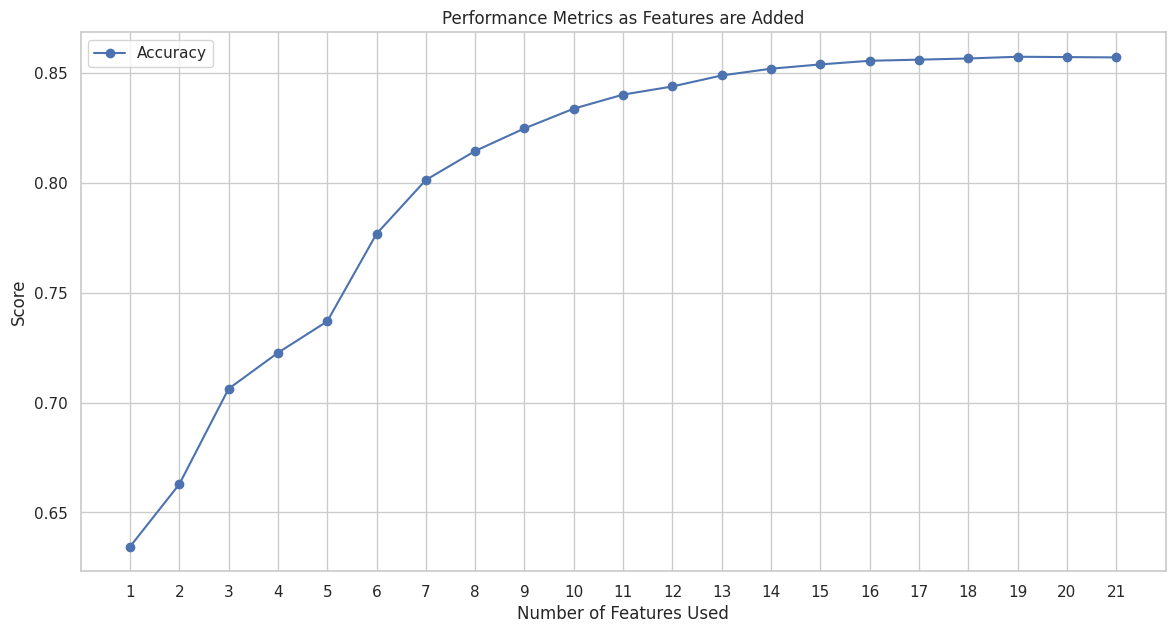

In [22]:


# Après avoir accumulé les résultats dans 'results_df'

# Tracé des performances au fil de l'ajout des caractéristiques
plt.figure(figsize=(14, 7))

# Tracer l'accuracy
plt.plot(results_df['Feature Count'], results_df['Accuracy'], label='Accuracy', marker='o')

plt.title('Performance Metrics as Features are Added')
plt.xlabel('Number of Features Used')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(features_sorted_by_importance) + 1))  # Ajuster les ticks pour correspondre au nombre de caractéristiques
plt.show()


## **Modelisation**

###Formation des données d'entrainnement et des données de test (80% / 20% )

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Evaluation

####Fonction d'évalution des model avec Matrice de prédiction, Accurancy, F1_score, Précision

In [24]:

def evaluation(model):

    model.fit(X_train, y_train.ravel())
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))


#Models entrainnés et testés : Knn, RandomForest, Adaboost

#Données déséquilibré : technique de réechantillonage utilisé : oversampligue


##**1er Cas** : Configuration du RandomForest  avec des ajustements pour gérer le déséquilibre des classes


###Conclusion : On constate que en se basant sur l'accurancy RandomForest a les meilleurs performences cependant en introduisant le recall et le f1_score on constate que en moyenne adaboost est meilleur

In [25]:
# Configuration des modèles avec des ajustements pour gérer le déséquilibre des classes
RandomForest = RandomForestClassifier(class_weight='balanced', random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
KNN = KNeighborsClassifier()

dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'KNN': KNN
                 }

In [26]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

RandomForest
[[42300  1225]
 [ 6105  1106]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     43525
           1       0.47      0.15      0.23      7211

    accuracy                           0.86     50736
   macro avg       0.67      0.56      0.58     50736
weighted avg       0.82      0.86      0.82     50736

AdaBoost
[[42496  1029]
 [ 5840  1371]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43525
           1       0.57      0.19      0.29      7211

    accuracy                           0.86     50736
   macro avg       0.73      0.58      0.61     50736
weighted avg       0.84      0.86      0.83     50736

KNN
[[41549  1976]
 [ 5704  1507]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     43525
           1       0.43      0.21      0.28      7211

    accuracy                           0.85     50736
   macro 

##**2ème Cas** : configuration de tous les models avec des ajustements pour gérer le déséquilibre des classes

###conclusion : de meme dans ce 2ème cas aussi, On constate que en se basant sur l'accurancy RandomForest a les meilleurs performences cependant en introduisant le recall et le f1_score on constate que en moyenne adaboost est meilleur.

###Alors pour des raisons liées au thème de détection du diabete, nous retenons le model **"ADABOOST"** sous la base du recall

**Random Forest Results:**

In [27]:

# Entraînement du modèle Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
rf.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = rf.predict(X_test)

# Évaluation des performances
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}\n")


Random Forest Results:
Accuracy: 0.8555
Recall: 0.1534
F1 Score: 0.2318



**AdaBoost Results:**

In [28]:


# Rééquilibrage des données d'entraînement
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entraînement du modèle AdaBoost
ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train_resampled, y_train_resampled)

# Prédiction sur l'ensemble de test
y_pred_ada = ada.predict(X_test)

# Évaluation des performances
accuracy_ada = accuracy_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

print(f"AdaBoost Results:")
print(f"Accuracy: {accuracy_ada:.4f}")
print(f"Recall: {recall_ada:.4f}")
print(f"F1 Score: {f1_ada:.4f}\n")


AdaBoost Results:
Accuracy: 0.7563
Recall: 0.7032
F1 Score: 0.4506



**KNN Results:**

In [29]:

# Rééquilibrage des données d'entraînement
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entraînement du modèle KNN
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)

# Prédiction sur l'ensemble de test
y_pred_knn = knn.predict(X_test)

# Évaluation des performances
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"KNN Results:")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}\n")


KNN Results:
Accuracy: 0.7074
Recall: 0.6357
F1 Score: 0.3818



# **Le modèle retenu est Adaboost**

# OPTIMISATION DU MODEL AVEC L'APPROCHE GRIDSHEARCH

In [ ]:


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(AdaBoostClassifier(random_state=0), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Meilleurs paramètres: ", grid_search.best_params_)
ada_best = grid_search.best_estimator_


Meilleurs paramètres:  {'learning_rate': 1, 'n_estimators': 200}


###Plus on augmente n_estimators plus on gagne en accurancy mais on perd en recall

In [30]:
# Création du modèle AdaBoost avec les paramètres optimisés
ada_optimized = AdaBoostClassifier(n_estimators=200, learning_rate=1, random_state=0)

# Entraînement du modèle AdaBoost
ada_optimized.fit(X_train_resampled, y_train_resampled)

# Prédiction sur l'ensemble de test
y_pred_optimized = ada_optimized.predict(X_test)

# Évaluation des performances
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)

# Affichage des résultats
print("AdaBoost Optimized Results:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}\n")


AdaBoost Optimized Results:
Accuracy: 0.7959
Recall: 0.6039
F1 Score: 0.4569



###Enregistrement du model

In [31]:
!pip install joblib


In [32]:

# Enregistrement du modèle AdaBoost
dump(ada_optimized, 'ada_optimized.joblib')


['ada_optimized.joblib']

### PREDICTION D'UN NOUVEL INDIVIDU

In [33]:

# Exemple de vecteur de données
data_vector = {
  "BMI": [-5],  # un indice de masse corporelle exemple
  "Age": [45],  # l'âge du patient
  "GenHlth": [3],  # une évaluation générale de la santé sur une échelle de 1 (excellente) à 5 (mauvaise)
  "Income": [55000],  # revenu annuel
  "HighBP": [1],  # haute pression sanguine, 1 si oui, 0 si non
  "PhysHlth": [2],  # nombre de jours de mauvaise santé physique le mois dernier
  "Education": [4],  # niveau d'éducation, supposons 1-4 où 4 est le plus élevé
  "MentHlth": [5],  # nombre de jours de mauvaise santé mentale le mois dernier
  "HighChol": [1],  # cholestérol élevé, 1 si oui, 0 si non
  "Smoker": [0],  # fumeur, 1 si oui, 0 si non
  "Fruits": [1],  # consomme des fruits quotidiennement, 1 si oui, 0 si non
  "DiffWalk": [0],  # a des difficultés à marcher, 1 si oui, 0 si non
  "Sex_1": [0],  # sexe, 1 si masculin, 0 si féminin
  "PhysActivity": [1],  # activité physique régulière, 1 si oui, 0 si non
  "Veggies": [1],  # consomme des légumes quotidiennement, 1 si oui, 0 si non
  "HeartDiseaseorAttack_1": [0],  # antécédent de maladie cardiaque ou d'attaque, 1 si oui, 0 si non
  "NoDocbcCost_1": [0],  # n'a pas consulté un docteur en raison du coût, 1 si oui, 0 si non
  "Stroke_1": [0],  # antécédent d'AVC, 1 si oui, 0 si non
  "HvyAlcoholConsump": [0],  # consommation lourde d'alcool, 1 si oui, 0 si non
  "AnyHealthcare_1": [1],  # a accès aux soins de santé, 1 si oui, 0 si non
  "CholCheck": [1]  # a eu un test de cholestérol dans les 5 dernières années, 1 si oui, 0 si non
}

def prediction(df):
  # Conversion en DataFrame
  data_df = pd.DataFrame(data_vector)

  ada_optimized = load('ada_optimized.joblib')
  # Vous pouvez maintenant utiliser `data_df` avec votre fonction de prédiction
  predicted_class= ada_optimized.predict(data_df)
  print("Prédiction de classe :", predicted_class)
  return predicted_class

prediction(data_vector)

Prédiction de classe : [0]


array([0])